# MODIS-WRF LST-TSK alignment validation testing - Future WRF

Validating the transformed WRF data each step of the way.

Test locations:  
  * 64.8N, 147.7W - MODIS tile h11v02 (**L1**)
  * 65.5N, 143.8W - MODIS tile h12v02 (**L2**)
  
Test time periods:
  * 2008-01-01 to 2008-04-01 (**P1**)
  * 2018-07-01 to 2018-10-01 (**P2**)

In [120]:
# setup
import os, glob, math, itertools, time
import xarray as xr
import pandas as pd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from pyproj import Transformer
from datetime import datetime
from rasterio.windows import Window
from rasterio.plot import show
%matplotlib inline

test_coords = np.array([[-147.7, 64.8], [-143.8, 65.5]])
test_dates = np.array(
    [["2038-04-01", "2038-07-01"], ["2067-07-01", "2067-09-30"]], dtype="datetime64"
)

scratch_dir = os.getenv("SCRATCH_DIR")
out_dir = os.getenv("OUTPUT_DIR")

## Compare output WRF with manual calculations

### Read raw WRF

In [254]:
# setup
wrf_dir = os.getenv("WRF_1KM_DIR")
era_dir = os.path.join(wrf_dir, "gfdl")
# filepaths for each period
wrf_fps = [glob.glob(os.path.join(era_dir, yr, "*.nc")) for yr in ["2038", "2067"]]
wrf_fps = [fp for fp in itertools.chain.from_iterable(wrf_fps)]
# sample filepath
samp_fp = wrf_fps[0]

In [247]:
# get list of variables to drop except time, lat, lon, and tsk
ds = xr.open_dataset(samp_fp)
keep = ["time", "lat", "lon", "TSK"]
drop_vars = [varname for varname in list(ds.variables.keys()) if varname not in keep]
ds.close()

In [248]:
# function to return arr indices of locations
def get_idx(ds,lonlat):
    def dist(arr,lon,lat):
        return math.sqrt((arr[0] - lon)**2 + (arr[1] - lat)**2)
    arr = np.stack((ds.lon.values, ds.lat.values))
    dists = np.apply_along_axis(dist, 0, arr, *lonlat)
    indices = np.where(dists == dists.min())
    return tuple([idx[0] for idx in indices])

In [249]:
# get arr indices of test locations
ds = xr.open_dataset(samp_fp, drop_variables=drop_vars)
L1_idx = get_idx(ds, test_coords[0])
L2_idx = get_idx(ds, test_coords[1])
ds.close()
idxs = [L1_idx, L2_idx]

In [250]:
# get dates for MODIS 8-day start dates
def get_dates(fp, test_dates):
    dates = pd.read_csv(fp)
    dates = dates.set_index("time")
    dates = dates[str(test_dates[0]): str(test_dates[1])].index.values.astype("datetime64")
    start, end = dates[0:-1], dates[1:]
    dates = np.stack([start, end], axis=1)
    return dates

In [251]:
# start dates are equal between MOD and MYD
# there are two periods of future dates
fut1_dates_fp = os.path.join(scratch_dir, "WRF", "WRF_day_hours-slim", "tsk", "tsk_max_8Day_daytime_wrf_gfdl_2037-2047_times.csv")
fut2_dates_fp = fut1_dates_fp.replace("2037-2047", "2067-2077")
fut1_dates = get_dates(fut1_dates_fp, test_dates[0])
fut2_dates = get_dates(fut2_dates_fp, test_dates[1])
dates = np.array([fut1_dates, fut2_dates])

In [263]:
# subset filepaths by dates for efficiency
# contain both periods in single 
fp_dates = [pd.date_range(dates[0], dates[1]).date.tolist() for dates in test_dates]
fp_dates = [[str(date) for date in dates_lst] for dates_lst in fp_dates]
fp_dates = fp_dates[0] + fp_dates[1]
#fp_dates = [str(date) for date in itertools.chain.from_iterable(fp_dates)]
wrf_fps = [fp for fp in wrf_fps if fp.split("_")[-2] in fp_dates]

In [235]:
# subset filepaths by dates for efficiency
# fp_dates = [pd.date_range(dates[0], dates[1]).date.tolist() for dates in test_dates]
# fp_dates = [str(date) for date in itertools.chain.from_iterable(fp_dates)]
# wrf_fps = [fp for fp in wrf_fps if fp.split("_")[-2] in fp_dates]

In [265]:
def get_day_hours(hr):
    return (hr >= 9) & (hr <= 17)

def get_day_hours_ds(ds):
    ds_sel = ds.sel(Time=get_day_hours(ds["time.hour"]))
    return ds_sel

def extr_arrs(ds, dates, idxs):
    arr = ds.TSK.values
    times = pd.to_datetime(ds.time.values)
    # extract from array based on indicies of time array using index slicer
    L1,L2 = [],[]
    out_sl = []
    for period in dates:
        slices = [times.slice_indexer(str(daterange[0]), str(daterange[1])) for daterange in period]
        out_sl.append(slices)
        L1.append([np.mean(arr[sl, idxs[0][0], idxs[0][1]]) for sl in slices])
        L2.append([np.max(arr[sl, idxs[1][0], idxs[1][1]]) for sl in slices])
    # return slices used for WRF as well
    return(np.array([np.array(L1), np.array(L2)]))

In [266]:
tic = time.perf_counter()

# read in raw WRF, takes a couple minutes
ds = xr.open_mfdataset(
    wrf_fps,
    drop_variables=drop_vars + ["lat", "lon"],
    concat_dim="Time",
    combine="nested",
    preprocess=get_day_hours_ds,
).load()

print(round(time.perf_counter() - tic, 1), "s")

582.8 s


In [267]:
ds.close()

In [268]:
wrf_arrs = extr_arrs(ds, dates, idxs)

In [118]:
wrf_arrs

array([[[274.6339 , 273.83566, 275.3131 , 277.11035, 279.39206,
         284.06802, 284.39346, 283.6838 , 284.36667, 286.3509 ],
        [291.26456, 290.25406, 289.82043, 288.17807, 288.7056 ,
         287.14203, 286.33542, 285.51654, 280.3988 , 276.91772]],

       [[270.90527, 269.3557 , 273.76273, 276.56277, 278.71457,
         283.4811 , 283.13712, 283.52386, 282.76395, 284.50238],
        [289.79132, 289.02158, 289.27948, 287.5911 , 288.10962,
         286.62598, 286.0252 , 284.7248 , 279.2848 , 275.289  ]]],
      dtype=float32)

### Read output WRF

In [121]:
wrf_out_dir = os.path.join(out_dir, "WRF", "tsk_1km_3338-slim")
# separate time periods spread across different files
wrf_out1_fp = os.path.join(wrf_out_dir, "tsk_gfdl_max_2037-2047.nc")
wrf_out2_fp = os.path.join(wrf_out_dir, "tsk_gfdl_max_2067-2077.nc")
wrf_out1_ds = xr.open_dataset(wrf_out1_fp)
wrf_out2_ds = xr.open_dataset(wrf_out2_fp)
wrf_out1_ds.close()
wrf_out2_ds.close()

In [138]:
def extr_wrf_out_arrs(ds, coords, dates):
    out_arrs = []
    for lcoords in coords:
        sds = ds.sel(xc=lcoords[0], yc=lcoords[1], method="nearest")
        out_arrs.append(sds.sel(date=slice(dates[0,0], dates[-1,0])).tsk.values)
    #out_arrs = np.array([out_arrs[:2], out_arrs[2:]])
    out_arrs = np.array(out_arrs)
    return out_arrs

In [122]:
transformer = Transformer.from_crs(4326, 3338, always_xy=True)
test_coords_3338 = [pt for pt in transformer.itransform(test_coords)]

In [152]:
wrf_out1_arrs = extr_wrf_out_arrs(wrf_out1_ds, test_coords_3338, dates[0])
wrf_out2_arrs = extr_wrf_out_arrs(wrf_out2_ds, test_coords_3338, dates[1])
wrf_out_arrs = np.stack([wrf_out1_arrs, wrf_out2_arrs], axis=1)

### Compare raw data with output (final)

In [154]:
def plot_delta_histograms(t_arrs1, t_arrs2, b_arrs1, b_arrs2):
    plot_arrs = []
    t_arrs = [t_arrs1, t_arrs2]
    b_arrs = [b_arrs1, b_arrs2]
    for t_arr, b_arr in zip(t_arrs, b_arrs):
        arr = t_arr - b_arr
        plot_arrs.append([sub_arr[~np.isnan(sub_arr)] for sub_arr in arr])
    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].hist(plot_arrs[0][0])
    ax[1].hist(plot_arrs[0][1])
    ax[2].hist(plot_arrs[1][0])
    ax[3].hist(plot_arrs[1][1])
    ax[0].title.set_text("L1, P1")
    ax[1].title.set_text("L1, P2")
    ax[2].title.set_text("L2, P1")
    ax[3].title.set_text("L2, P2")
    plt.show()

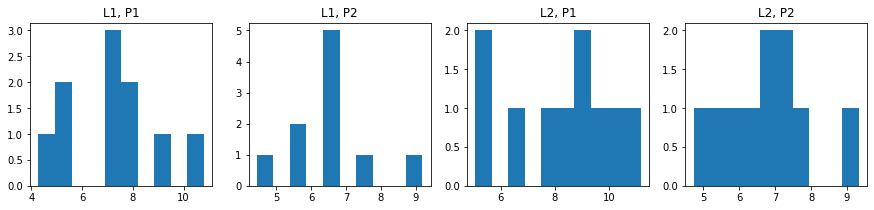

In [155]:
plot_delta_histograms(wrf_out_arrs[0], wrf_out_arrs[1], wrf_arrs[0], wrf_arrs[1])

These are the types of subtle differences I would expect from warping 4326 to 3338. Not to mention that the original grid is irregular in 4326.

Compare a slice in time from each:

In [157]:
!ls $SCRATCH_DIR/WRF/tsk_1km_3338-slim/gfdl_max_2037-2047

tsk_8Day_daytime_wrf_gfdl_max_2037183_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037191_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037199_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037207_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037215_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037223_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037231_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037239_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037247_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037255_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037263_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037271_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037279_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037287_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037295_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2037303_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2038090_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2038098_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2038106_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2038114_3338.tif
tsk_8Day_daytime_wrf_gfdl_max_2038122_3338.tif
tsk_8Day_dayt

In [160]:
!ls $OUTPUT_DIR/WRF/tsk_1km_3338-slim

tsk_ccsm_max_2007-2017.nc  tsk_era_max_2000-2018.nc   tsk_gfdl_max_2067-2077.nc
tsk_ccsm_max_2037-2047.nc  tsk_gfdl_max_2007-2017.nc
tsk_ccsm_max_2067-2077.nc  tsk_gfdl_max_2037-2047.nc


In [161]:
wrf_in_sl_dir = os.path.join(scratch_dir, "WRF", "tsk_1km_3338-slim", "gfdl_max_2037-2047", "*")
wrf_in_sl_fp = sorted(glob.glob(wrf_in_sl_dir))[0]
wrf_out_sl_fp = os.path.join(out_dir, "WRF", "tsk_1km_3338-slim", "tsk_gfdl_max_2037-2047.nc")

In [165]:
wrf_in_sl = rio.open(wrf_in_sl_fp).read(1)
wrf_in_sl[wrf_in_sl == -9999] = np.nan

In [202]:
def plot_slices(model, year_range, sl_idx):
    wrf_in_dir = os.path.join(scratch_dir, "WRF", "tsk_1km_3338-slim", f"{model}_max_{year_range}")
    suffix = os.path.basename(wrf_in_dir)
    wrf_in_fp = sorted(glob.glob(os.path.join(wrf_in_dir, "*")))[sl_idx]
    wrf_out_fp = os.path.join(out_dir, "WRF", "tsk_1km_3338-slim", f"tsk_{suffix}.nc")
    wrf_in_sl = rio.open(wrf_in_fp).read(1)
    wrf_in_sl[wrf_in_sl == -9999] = np.nan
    print(np.nanmin(wrf_in_sl), np.nanmax(wrf_in_sl))
    wrf_out_ds = xr.open_dataset(wrf_out_fp)
    wrf_out_ds.close()
    wrf_out_sl = wrf_out_ds.tsk.values[sl_idx,...]
    wrf_out_sl[wrf_out_sl == -9999] = np.nan
    print(np.nanmin(wrf_out_sl), np.nanmax(wrf_out_sl))
    fig, ax = plt.subplots(1,2, figsize=(15,20))
    ax[0].imshow(wrf_in_sl, interpolation="none", vmin=260, vmax=300)
    ax[1].imshow(wrf_out_sl, interpolation="none", vmin=260, vmax=300)
    ax[0].title.set_text("Warped to epsg:3338")
    ax[1].title.set_text("Regridded (downsampled) to MODIS, epsg:3338")
    plt.show()

273.15 298.40768
285.0034 298.40768


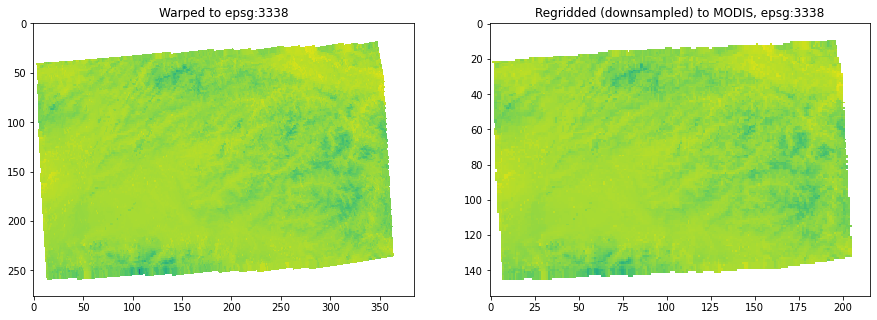

In [203]:
plot_slices("gfdl", "2037-2047", 0)

273.15 303.27762
289.55838 303.26602


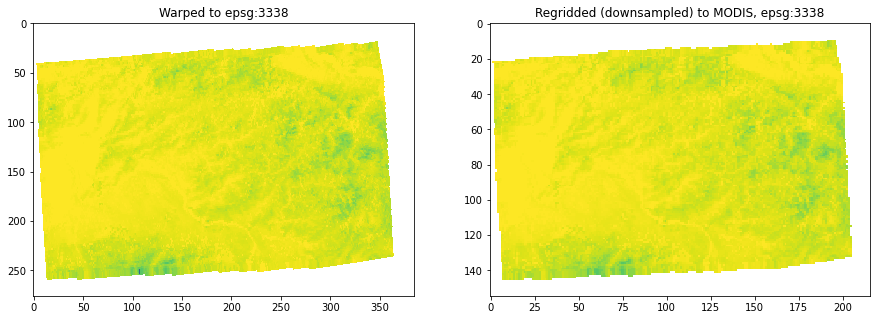

In [204]:
plot_slices("gfdl", "2067-2077", 0)

273.13065 286.76154
273.13065 286.76154


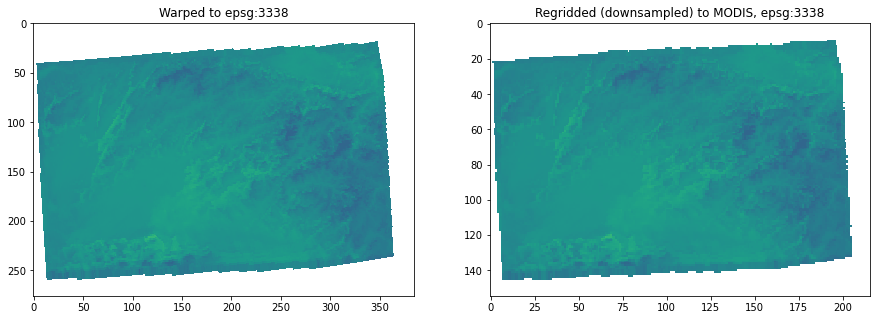

In [205]:
plot_slices("era", "2000-2018", 50)

273.15 293.29932
273.38986 292.90378


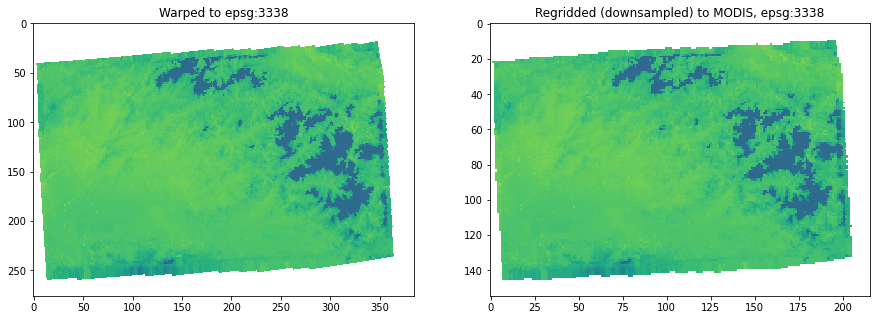

In [207]:
plot_slices("gfdl", "2007-2017", 50)

273.15 299.61334
283.21796 299.61334


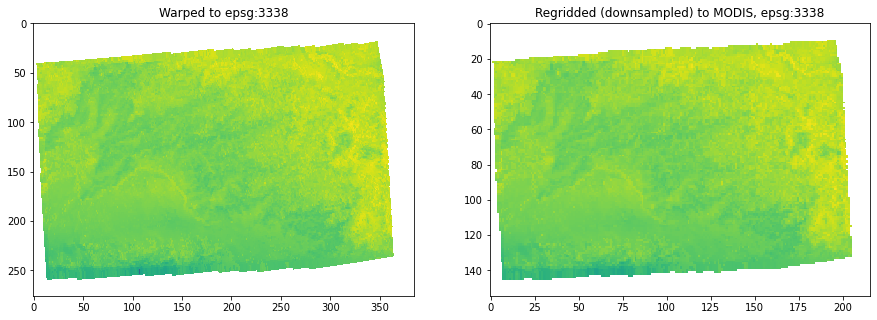

In [216]:
plot_slices("ccsm", "2007-2017", 25)

273.15 288.9849
273.28156 288.9849


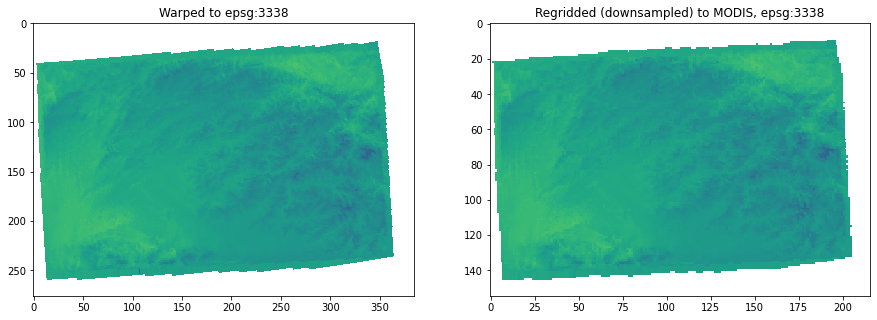

In [217]:
plot_slices("ccsm", "2037-2047", 200)

271.45505 284.50464
271.5955 281.9985


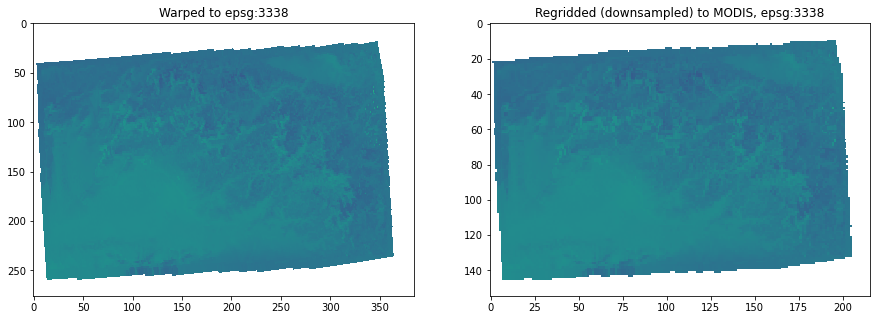

In [218]:
plot_slices("ccsm", "2067-2077", 38)

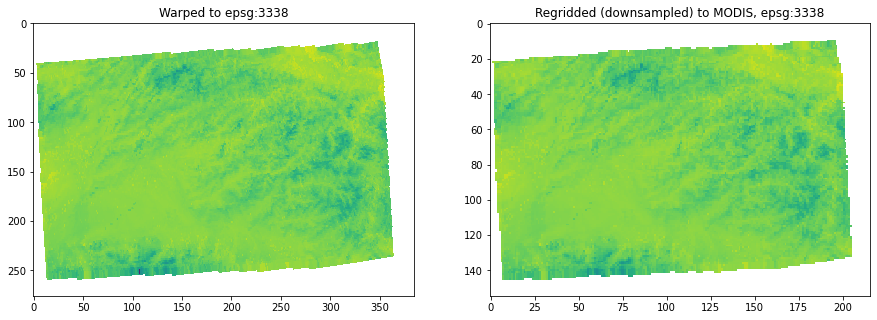

In [172]:
fig, ax = plt.subplots(1,2, figsize=(15,20))
ax[0].imshow(wrf_in_sl, interpolation="none", vmin=270, vmax=300)
ax[1].imshow(wrf_out_sl, interpolation="none", vmin=270, vmax=300)
ax[0].title.set_text("Warped to epsg:3338")
ax[1].title.set_text("Regridded (downsampled) to MODIS, epsg:3338")
plt.show()

In [173]:
print("Warped WRF shape:", wrf_in_sl.shape)
print("Regridded WRF shape:", wrf_out_sl.shape)

Warped WRF shape: (276, 385)
Regridded WRF shape: (155, 216)


As expected, example looks the same but is at the lower resolution of the MODIS LST.

### Output WRF values sanity check

Now to perform the same basic sanity check on all files of output WRF, to ensure that all values are either `nodata` (-9999) or not extreme. 

Since there are 18 combinations of metric, model, and sensor, all created using the same script, this will test one unique set corresponding to each sensor: `era_mean_MOD11A2`, `gfdl_max_MYD11A2`.

In [73]:
wrf_out_dir = wrf_out_dir.replace("_multiband", "")
wrf1_out_fps = sorted(glob.glob(os.path.join(wrf_out_dir, "era_mean_MOD11A2", "*")))
wrf2_out_fps = sorted(glob.glob(os.path.join(wrf_out_dir, "gfdl_max_MYD11A2", "*")))

In [74]:
wrf1_out_arr = get_all_data(wrf1_out_fps)
wrf2_out_arr = get_all_data(wrf2_out_fps)

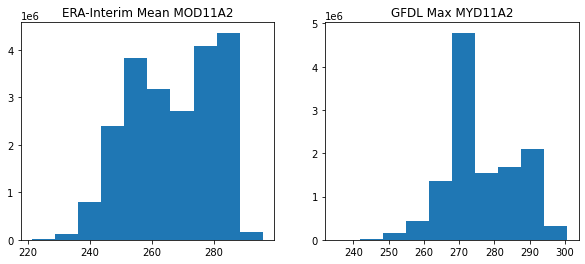

In [75]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].hist(wrf1_out_arr[~np.isnan(wrf1_out_arr)])
ax[1].hist(wrf2_out_arr[~np.isnan(wrf2_out_arr)])
ax[0].title.set_text("ERA-Interim Mean MOD11A2")
ax[1].title.set_text("GFDL Max MYD11A2")
plt.show()

## 3. WRF-MODIS alignment

Finally, verify that the output data of each source are actually aligned in time and space.

#### Compare NetCDF datasets:

In [76]:
mod_ds = xr.open_dataset(mod_out_fp)
print(mod_ds)
mod_ds.close()

<xarray.Dataset>
Dimensions:  (date: 931, xc: 216, yc: 155)
Coordinates:
  * xc       (xc) float64 1.904e+05 1.921e+05 1.937e+05 ... 5.504e+05 5.521e+05
  * yc       (yc) float64 1.8e+06 1.798e+06 1.796e+06 ... 1.542e+06 1.541e+06
  * date     (date) datetime64[ns] 2000-02-18 2000-02-26 ... 2020-05-16
Data variables:
    lst      (date, yc, xc) float32 ...
Attributes:
    title:          1km WRF-ailgned MODIS LST
    creation_time:  2020-08-05 12:01:19
    epsg:           3338
    hdf_source:     MOD11A2.A2000049.h11v02.006.2015058135049.hdf
    SNAP_version:   0.1.0


In [77]:
wrf_ds = xr.open_dataset(wrf_out_fp)
print(wrf_ds)
wrf_ds.close()

<xarray.Dataset>
Dimensions:  (date: 866, xc: 216, yc: 155)
Coordinates:
  * xc       (xc) float64 1.904e+05 1.921e+05 1.937e+05 ... 5.504e+05 5.521e+05
  * yc       (yc) float64 1.8e+06 1.798e+06 1.796e+06 ... 1.542e+06 1.541e+06
  * date     (date) datetime64[ns] 2000-02-18 2000-02-26 ... 2018-12-19
Data variables:
    tsk      (date, yc, xc) float32 ...
Attributes:
    title:          1km MODIS-ailgned WRF TSK
    creation_time:  2020-08-05 14:05:50
    epsg:           3338
    nc_source:      WRFDS_2000-02-21_serdp.nc
    SNAP_version:   0.1.0


The `date` dimension is longer for the MODIS dataset because there is more data available than for the WRF ERA-Interim. This looks OK - matching values for the coordiantes. 

#### Compare centerpoints

Compare the centerpoints of the first row/column between the two different sources, they should all be equal. Compare one GeoTIFF from each model/metric/sensor combination with the MOD11A2

In [78]:
with rio.open(mod_out_fps[0]) as src:
    hidx,widx = np.arange(src.height), np.arange(src.width)
    mod_cp_arr = np.array(
        [src.xy(0,j) for j in widx] + [src.xy(i,0) for i in hidx][1:]
    )

In [79]:
# get centerpoints
def get_center_points(fps):
    cp_arrs = []
    for fp in fps:
        with rio.open(fp) as src:
            hidx,widx = np.arange(src.height), np.arange(src.width)
            cp_arr = np.array(
                [src.xy(0,j) for j in widx] + [src.xy(i,0) for i in hidx][1:]
            )
        cp_arrs.append(cp_arr)
    return cp_arrs

In [80]:
wrf_subdirs = os.listdir(wrf_out_dir)
wrf_out_fps = [glob.glob(os.path.join(wrf_out_dir, wrf_subdir, "*"))[0] for wrf_subdir in wrf_subdirs]

In [81]:
wrf_cp_arrs = get_center_points(wrf_out_fps)

List of comparisons between the MODIS centerpoints and WRF centerpoints: 

In [82]:
np.all([np.all(mod_cp_arr == wrf_cp_arr) for wrf_cp_arr in wrf_cp_arrs])

True

All equal. Finally, visually compare some slices in time from some of the various outputs.

In [83]:
mod_out_fps[0]

'/home/kmredilla/tech-projects/SERDP-fish-and-fire/project-data/MODIS/lst_1km_3338/lst_MOD11A2_InteriorAK_2000049_3338.tif'

In [84]:
def show_both_src(mod_fp, wrf_fp):
    wrf_title = " ".join(os.path.basename(wrf_fp).split("_")[-5:-1])
    mod_tags = os.path.basename(mod_fp).split("_")
    mod_title = " ".join([mod_tags[-4], mod_tags[-2]])
    src1 = rio.open(mod_fp)
    src2 = rio.open(wrf_fp)
    fig, (mod, wrf) = plt.subplots(1,2, figsize=(18,7))
    show((src1), ax=mod, title="MODIS LST {}".format(mod_title))
    show((src2), ax=wrf, title="WRF TSK {}".format(wrf_title))

##### MOD11A2

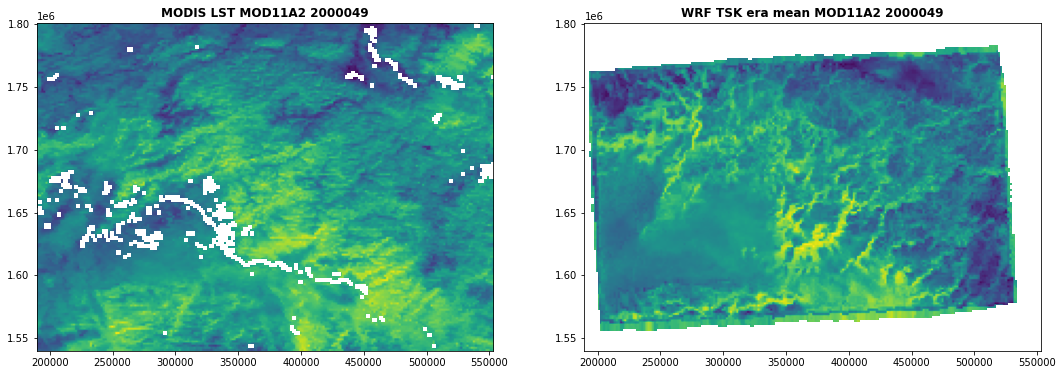

In [85]:
show_both_src(mod_out_fps[0], wrf_out_fps[0])

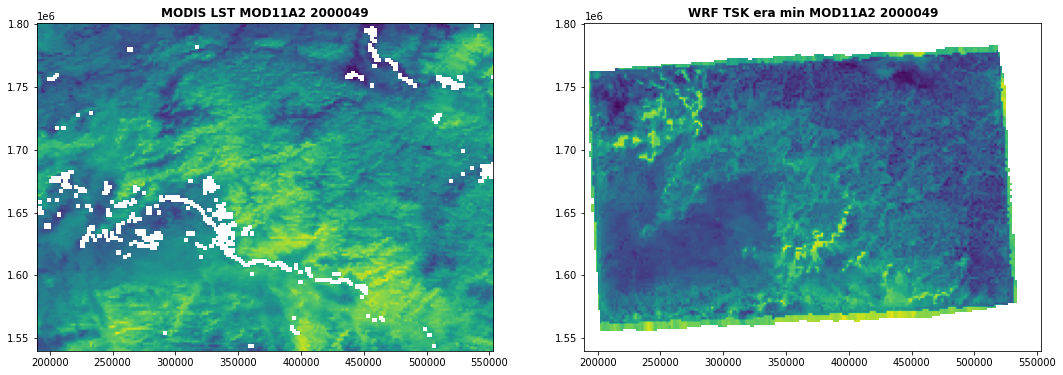

In [86]:
show_both_src(mod_out_fps[0], wrf_out_fps[1])

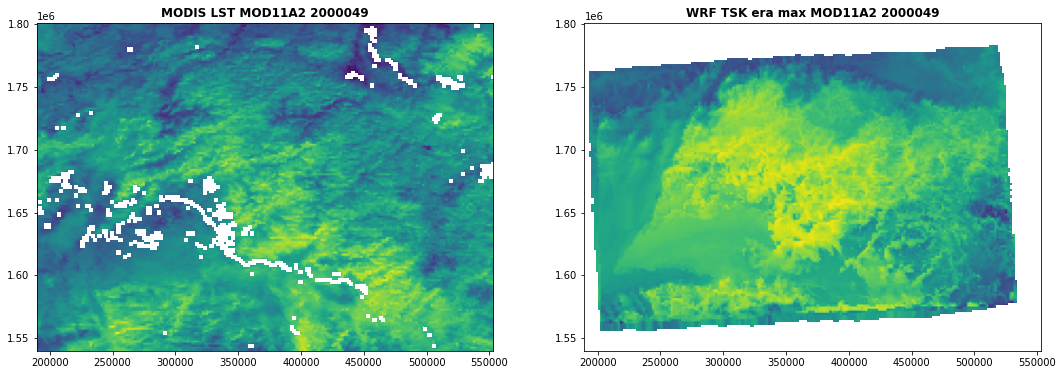

In [87]:
show_both_src(mod_out_fps[0], wrf_out_fps[2])

##### MYD11A2

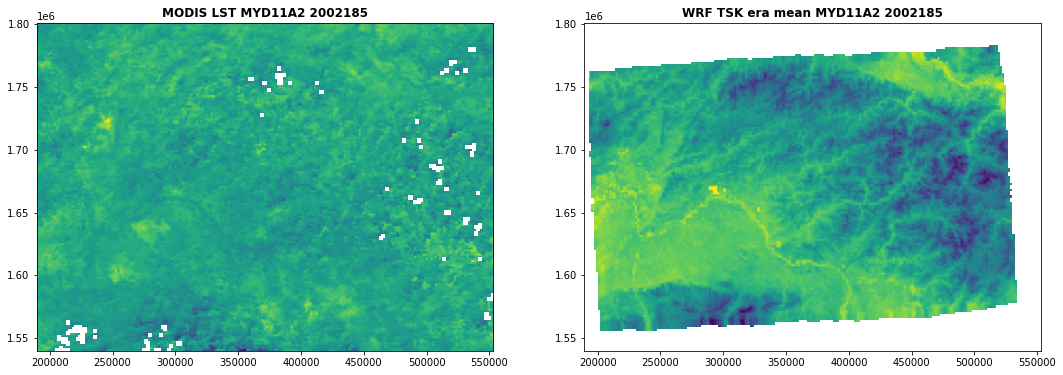

In [88]:
show_both_src(myd_out_fps[0], wrf_out_fps[3])

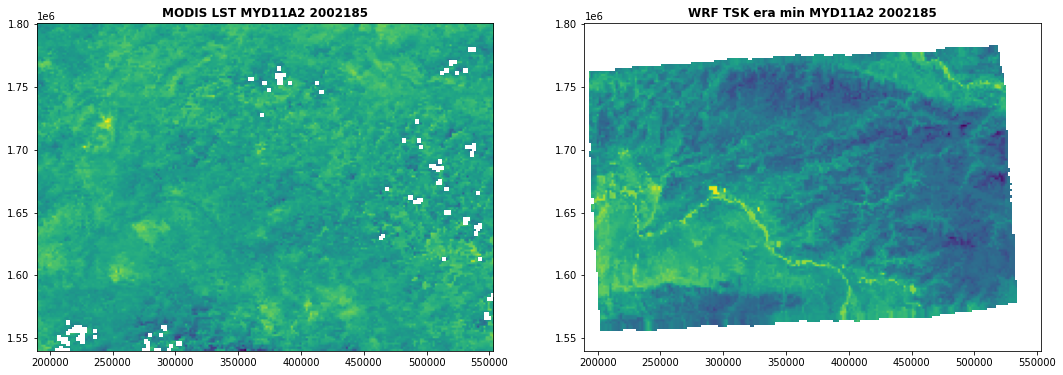

In [89]:
show_both_src(myd_out_fps[0], wrf_out_fps[4])

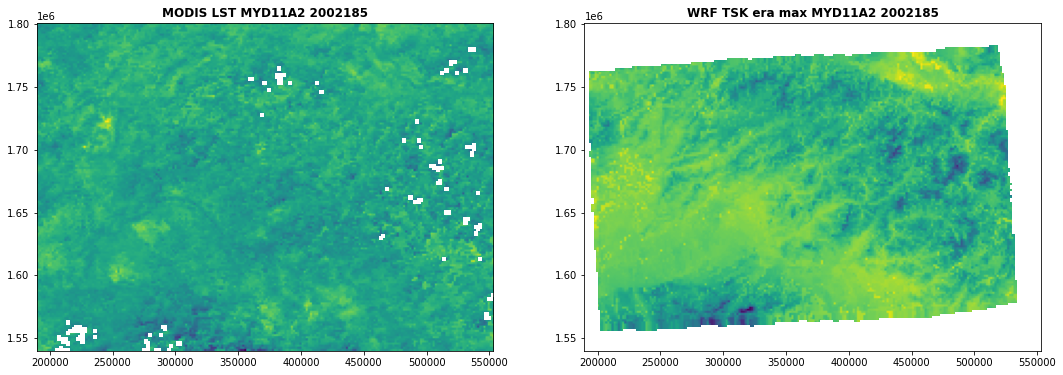

In [90]:
show_both_src(myd_out_fps[0], wrf_out_fps[5])

All data are aligned and appear to be valid. 